# Исследование надежности заемщиков

Это первый учебный проект, который проверяет знания основ языка python. В этом проекте необходимо проанализировать данные о платежеспособности клиентов банка и выявить закономерность различных характеристик клиентов с возвратом долга в срок.  

Первая половина проекта выполнялась по конкретным заданиям с единственным верным ответом. Во второй части проекта (шаг 3 и 4) необходимо было ответить на вопросы, для этого необходимо самостоятельно определить нужные вычисления и визуализации.

## Описание данных

- `children` — количество детей в семье
- `days_employed` — общий трудовой стаж в днях
- `dob_years` — возраст клиента в годах
- `education` — уровень образования клиента
- `education_id` — идентификатор уровня образования
- `family_status` — семейное положение
- `family_status_id` — идентификатор семейного положения
- `gender` — пол клиента
- `income_type` — тип занятости
- `debt` — имел ли задолженность по возврату кредитов
- `total_income` — ежемесячный доход
- `purpose` — цель получения кредита

## Шаг 1. Откройте таблицу и изучите общую информацию о данных

In [1]:
import seaborn
import pandas as pd

In [ ]:
try:
    data = pd.read_csv('/datasets/data.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/data.csv')

In [2]:
data.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


## Шаг 2. Предобработка данных

### Удаление пропусков

In [4]:
data.isna().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

In [5]:
for t in data['income_type'].unique():
    data.loc[(data['income_type'] == t) & (data['total_income'].isna()), 'total_income'] = \
    data.loc[(data['income_type'] == t), 'total_income'].median()

### Обработка аномальных значений

In [6]:
data['days_employed'] = data['days_employed'].abs()

In [7]:
data.groupby('income_type')['days_employed'].agg('median')

income_type
безработный        366413.652744
в декрете            3296.759962
госслужащий          2689.368353
компаньон            1547.382223
пенсионер          365213.306266
предприниматель       520.848083
сотрудник            1574.202821
студент               578.751554
Name: days_employed, dtype: float64

У двух типов (безработные и пенсионеры) получатся аномально большие значения. Исправить такие значения сложно, поэтому оставим их как есть. Тем более этот столбец не понадобится нам для исследования.

In [8]:
data['children'].unique()

array([ 1,  0,  3,  2, -1,  4, 20,  5], dtype=int64)

In [9]:
data = data[(data['children'] != -1) & (data['children'] != 20)]

In [10]:
data['children'].unique()

array([1, 0, 3, 2, 4, 5], dtype=int64)

### Удаление пропусков (продолжение)

In [13]:
#заполнить пропуски в столбце days_employed медианными значениями по каждого типа занятости income_type
for t in data['income_type'].unique():
    data.loc[(data['income_type'] == t) & (data['days_employed'].isna()), 'days_employed'] = \
    data.loc[(data['income_type'] == t), 'days_employed'].median()

In [12]:
data.isna().sum()

children            0
days_employed       0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
dtype: int64

### Изменение типов данных

In [14]:
data['total_income'] = data['total_income'].astype(int)

### Обработка дубликатов

In [15]:
data['education'] = data['education'].str.lower()

In [16]:
data.duplicated().sum()

71

In [17]:
data = data.drop_duplicates()

### Категоризация данных

In [18]:
def categorize_income(income):
    try:
        if 0 <= income <= 30000:
            return 'E'
        elif 30001 <= income <= 50000:
            return 'D'
        elif 50001 <= income <= 200000:
            return 'C'
        elif 200001 <= income <= 1000000:
            return 'B'
        elif income >= 1000001:
            return 'A'
    except:
        pass

In [19]:
data['total_income_category'] = data['total_income'].apply(categorize_income)

In [20]:
data['purpose'].unique()

array(['покупка жилья', 'приобретение автомобиля',
       'дополнительное образование', 'сыграть свадьбу',
       'операции с жильем', 'образование', 'на проведение свадьбы',
       'покупка жилья для семьи', 'покупка недвижимости',
       'покупка коммерческой недвижимости', 'покупка жилой недвижимости',
       'строительство собственной недвижимости', 'недвижимость',
       'строительство недвижимости', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля',
       'операции с коммерческой недвижимостью',
       'строительство жилой недвижимости', 'жилье',
       'операции со своей недвижимостью', 'автомобили',
       'заняться образованием', 'сделка с подержанным автомобилем',
       'получение образования', 'автомобиль', 'свадьба',
       'получение дополнительного образования', 'покупка своего жилья',
       'операции с недвижимостью', 'получение высшего образования',
       'свой автомобиль', 'сделка с автомобилем',
       'профильное образование', 'высшее об

In [21]:
def categorize_purpose(row):
    try:
        if 'автом' in row:
            return 'операции с автомобилем'
        elif 'жил' in row or 'недвиж' in row:
            return 'операции с недвижимостью'
        elif 'свад' in row:
            return 'проведение свадьбы'
        elif 'образов' in row:
            return 'получение образования'
    except:
        return 'нет категории'

In [22]:
data['purpose_category'] = data['purpose'].apply(categorize_purpose)

### Шаг 3. Исследуйте данные и ответьте на вопросы

#### 3.1 Есть ли зависимость между количеством детей и возвратом кредита в срок?

In [23]:
#найдем процент людей, имеющих задолженность, от всех людей с таким количеством детей
conversion_children = data.groupby('children')['debt'].sum() / data.groupby('children')['debt'].count() * 100
print(conversion_children)

children
0    7.543822
1    9.234609
2    9.454191
3    8.181818
4    9.756098
5    0.000000
Name: debt, dtype: float64


In [24]:
#в целом процент практически одинаковый, но выбивается значение по людям с 5 детьми, посмотрим сколько в целом у нас таких людей
data.groupby('children')['debt'].count()

children
0    14091
1     4808
2     2052
3      330
4       41
5        9
Name: debt, dtype: int64

<AxesSubplot:xlabel='children', ylabel='debt'>

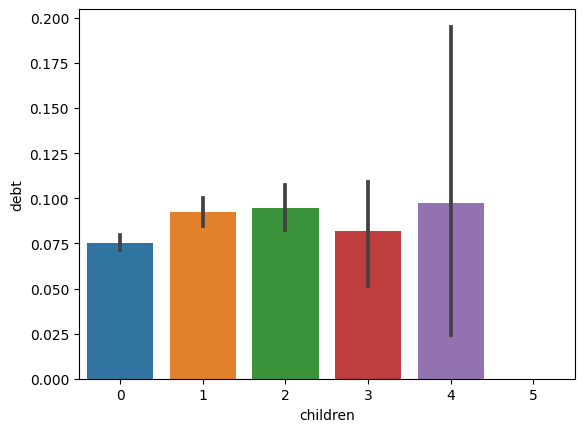

In [25]:
seaborn.barplot(x = data['children'], y = data['debt'])

**Вывод:** Люди с детьми и без детей отдают кредиты примерно одинаково. Люди без детей немного лучше отдают кредиты, но разница в 1-2% может быть погрешностью. Мы не можем из-за разницы в 1-2% считать отсутсвие детей ключевым фактором для одобрения кредита. 
У людей с 5 детьми вообще не было задолженностей по кредитам, но мы не можем брать эти данные во внимание, так как выборка не репрезентативна.

#### 3.2 Есть ли зависимость между семейным положением и возвратом кредита в срок?

In [26]:
#найдем процент людей, имеющих задолженность, от всех людей с таким же семейном положением
family_table = data.pivot_table(index = 'family_status', values = 'debt', aggfunc = ['sum', 'count', 'mean'])
family_table['mean'] = family_table['mean']*100
print(family_table)

                       sum  count      mean
                      debt   debt      debt
family_status                              
Не женат / не замужем  273   2796  9.763948
в разводе               84   1189  7.064760
вдовец / вдова          63    951  6.624606
гражданский брак       385   4134  9.313014
женат / замужем        927  12261  7.560558


<AxesSubplot:xlabel='debt', ylabel='family_status'>

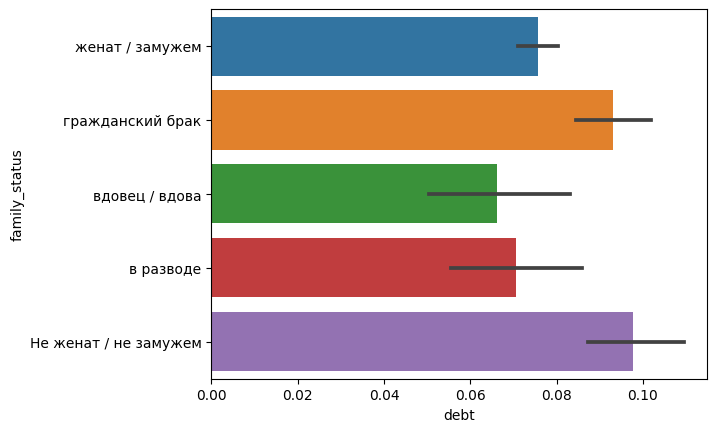

In [27]:
seaborn.barplot(x = data['debt'], y = data['family_status'])

**Вывод:** Самые плохие показатели у не замужних/не женатых людей и людей, состоящих в гражданском браке. Меньше всех имели задолженности по кредитам вдовы/вдовцы. Получается, что наличие 2 кормильцев в семье не влияет на возвращение кредита в срок.

#### 3.3 Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

In [28]:
#найдем процент людей, имеющих задолженность, от всех людей с таким же уровнем дохода
conversion_total_income = data.groupby('total_income_category').agg({'debt' : ['sum', 'count', 'mean']})
print(conversion_total_income)

                       debt                 
                        sum  count      mean
total_income_category                       
A                         2     25  0.080000
B                       354   5014  0.070602
C                      1353  15921  0.084982
D                        21    349  0.060172
E                         2     22  0.090909


<AxesSubplot:xlabel='total_income_category', ylabel='debt'>

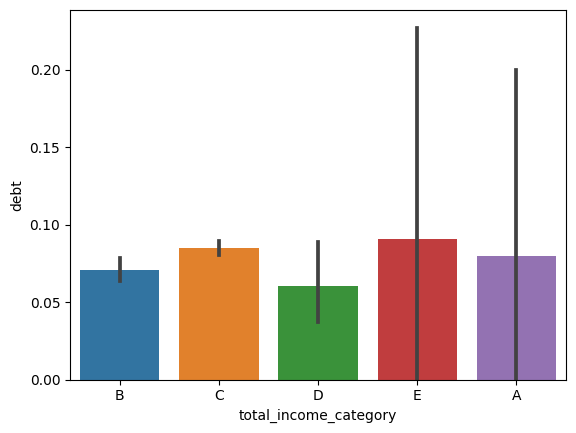

In [29]:
seaborn.barplot(x = data['total_income_category'], y = data['debt'])
#не понимаю почему категории идут не подряд, почему А перемещается в крайне правое положение?

**Вывод:** Люди с низкими доходами (категория E < 30000) возвращает кредиты хуже всего, что вполне логично - им не хватает на жизнь, они берут кредиты, а возвращать нечем. Самые лучшие показатели у людей с средним заработком, не превыщающем 50тыс. При этом люди со сверхвысоким доходом довольно часто не отдают кредиты в срок. Возможно, это связано с крупными объектами/проектами, которые несут в себе большие риски.  

#### 3.4 Как разные цели кредита влияют на его возврат в срок?

In [30]:
#найдем процент людей, имеющих задолженность, от всех людей с такой же целью кредита
purpose_table = data.pivot_table(index = 'purpose_category', values = 'debt', aggfunc = ['sum', 'count', 'mean'])
purpose_table['mean'] = purpose_table['mean']*100
print(purpose_table)

                          sum  count      mean
                         debt   debt      debt
purpose_category                              
операции с автомобилем    400   4279  9.347978
операции с недвижимостью  780  10751  7.255139
получение образования     369   3988  9.252758
проведение свадьбы        183   2313  7.911803


<AxesSubplot:xlabel='debt', ylabel='purpose_category'>

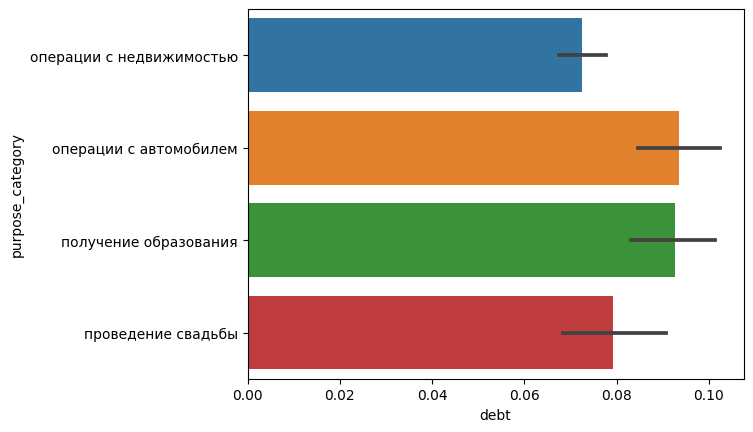

In [31]:
seaborn.barplot(x = data['debt'], y = data['purpose_category'])

**Вывод:** Лучше всего отдают кредиты люди, которые брали деньги для приобретения недвижимости. Это, в большинстве случаев, самая большая и дорогая покупка в жизни людей, к которой готовятся много лет и тщательно считают свои возможности. Плохие показатели показывают люди, которые берут деньги для приобретения автомобиля и получения образования. 

### Шаг 4: общий вывод.

В ходе работы были выявлены пропуски - заполнила их медианным значением по каждому типу занятости, также были выявлены и устранены аномалии (например, отрицательное (-1) или слишком большое (20) количество детей).
Были выявлены и удалены дубликаты (71) , которые образовались из-за использования разных регистров.  
Для удобства использования данных доходы людей распредилила по категориям, получилось 5 диапозонов:  
* 0–30000 — 'E';  
* 30001–50000 — 'D';  
* 50001–200000 — 'C';  
* 200001–1000000 — 'B';  
* 1000001 и выше — 'A'.  

Также при анализе целей кредита было выявлено, что люди берут кредиты на 4 цели:  
'операции с автомобилем', 'операции с недвижимостью', 'проведение свадьбы' и 'получение образования'.  


В ходе анализа было выявлено, что `наличие детей` сказывается `положительным образом` на возврат кредита в срок (на 1-2% люди с детьми отдают кредиты лучше), при этом `количество детей` в семье `не влияет` на возврат кредита в срок, также как и `не влияет наличие 2 кормильцев` в семье. При этом `не замужние/не женатые` люди и люди, состоящие в `гражданском браке` показывают `худший результат`, возможно, это связано с их возрастом. 
`Доходы людей влияют` на возврат кредита в срок, но самые `лучшие результаты` показывают люди со `средним` заработком, а вот люди с `очень низким заработком` (до 30 тысяч в месяц) и, наоборот, со `сверхвысоким` (больше 1 млн в месяц) показывают `худшие показатели` возврата кредита в срок. 
Если цель кредита `"операция с недвижимостью"  или " проведение свадьбы"`, то `вероятнее` (на 2%) кредит будет возвращен в срок, чем кредит, целью которого является `"получение образования"` или `"операции с автомобилем"`.  


**После полного анализа можно сделать вывод:**  
Явной зависимости возврата кредита в срок от наличия детей, семейного положения, уровня дохода и целью кредита нет, но есть общие тенденции, которые на больших цифрах могут влиять на кредитный портфель банка. Особое внимание следует уделять не замужним/не женатым людям с низкими доходами, берущими кредит на автомобиль или образование. Также следует более подробно изучать цель кредита у людей со сверхдоходами.  


При сборе данных лучше стаж считать в годах (мало кто знает свой стаж в днях), поле ежемесячный доход сделать обязательным к заполнению, а в поле количества детей сделать невозможным заполнение отрицательным значением.